Import the libraries

In [8]:
import torch as torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import os as os
import numpy as np
import pandas as pd
import csv as csv
from sklearn.model_selection import train_test_split
from PIL import Image as PilImage
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from torch.utils.data import  random_split
from torch.nn.functional import log_softmax
from datetime import datetime
from torch.nn.functional import cross_entropy

This is the dataset for loading the fashion data. We inherit from the 
pytorch dataset

In [9]:
class FashionDataset(Dataset):
    def __init__(self,images_tensor,labels_tensor,transforms=None):
        #We reshape our images to a nx1x28x28 array. 1 is for 1 channel
        self.images = images_tensor.reshape(images_tensor.shape[0], 1, 28, 28)
        self.labels = labels_tensor
        self.transform = transforms

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        #Get the image and label at the given index
        image = self.images[index]
        label = self.labels[index]
        if self.transform != None:
            image = self.transform(image)

        #Return the image and label
        return image, label

This is the Convolution Neural Network class.

In [10]:
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_unit_1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Second unit of convolution
        self.conv_unit_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        # Fully connected layers
        self.fc1 = nn.Linear(1568, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        out = self.conv_unit_1(x)
        out = self.conv_unit_2(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = log_softmax(out, dim=1)
        return out

Helper Functions

In [11]:
'''
This function allows us to see a subset of the images.
Code Reference: Labs
'''
def preview_images(preview_dl):
    """Plot images grid of single batch"""
    for batch in preview_dl:
        images, labels = batch
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=5).permute(1, 2, 0)) #Convert channelxWxH to WxHxchannel
        plt.show()
        break

'''
Calculate the accuracy
'''
def get_accuracy(outputs, labels):
    #As we are using softmax, get the column with the largest value. This
    #will correspond to the prediction
    values, indices = torch.max(outputs, dim=1)

    #Get the total number of rows that match and divide by the number of
    #indices to give an average accuracy
    return torch.tensor(torch.sum(indices == labels).item() / len(indices))

Read the data and preview

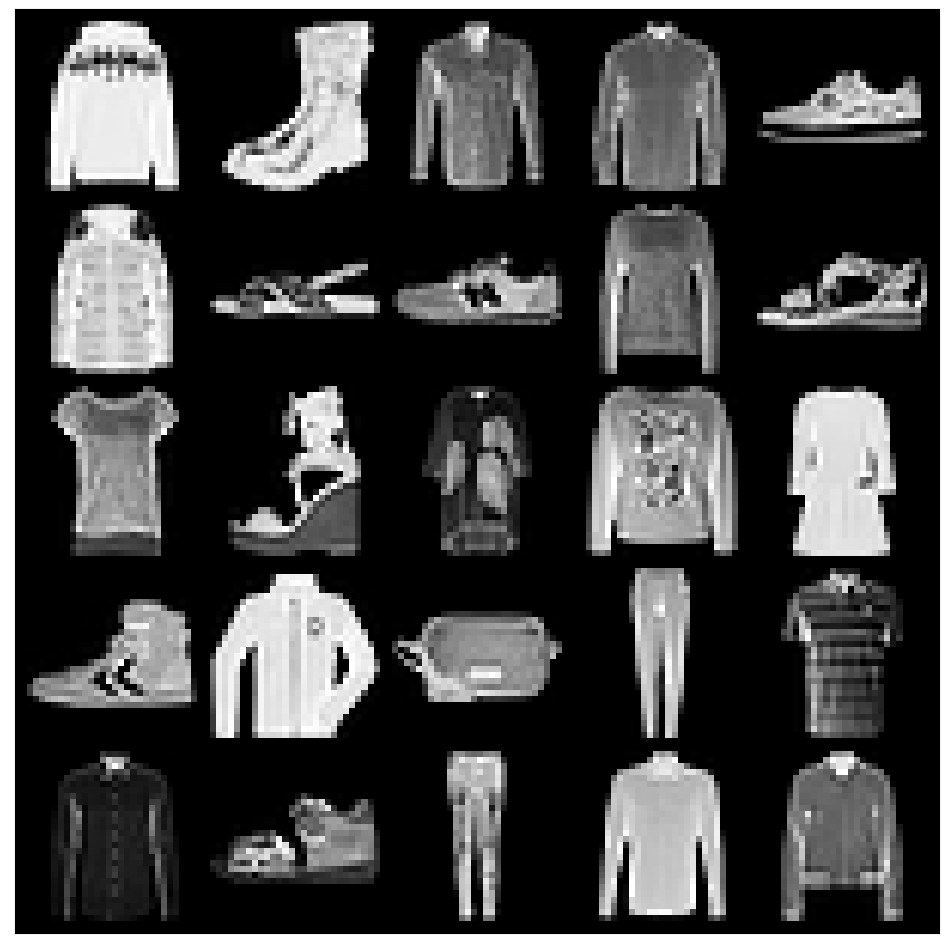

In [12]:

df = pd.read_csv("../data/fashion/fashion-mnist_train.csv")

# Get the labels
train_labels = df["label"].to_numpy()

# Get the image data
train_images = df[df.columns[df.columns != 'label']].to_numpy()

# Conver the images and labels to tensors
train_images_tensor = torch.tensor(train_images) / 255 # This is to normalise the data
train_labels_tensor = torch.tensor(train_labels)

# Let's create our FashionDataset
fashion_ds = FashionDataset(train_images_tensor,train_labels_tensor)

#Let's preview the data. We create a loader to assist
preview_loader = DataLoader(fashion_ds,25, shuffle=True)
preview_images(preview_loader)

In [ ]:

# Let's split our data into training and test data
train_dataset,test_dataset =  random_split(fashion_ds,[0.8,0.2])

# Create our data loader for getting the training images
train_loader = DataLoader(train_dataset, 10, shuffle = True)
test_loader =  DataLoader(test_dataset, 10, shuffle = True)

master_metrics_log = np.empty((0, 4), float)

#Create Model  instance
model = FashionCNN()

#Model Definition
print("Definition:",model)

#For this we will use CrossEntropyLoss with a SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
num_epochs = 10
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    print("Epoch:",epoch)
    start = datetime.now()
    accuracy_log = []
    loss_log = []
    accuracy = 0
    loss = 0
    for batch in train_loader:
        #Get the images and labels
        images, labels = batch
        # Forward pass
        outputs = model(images)
        #Calculate the accuracy and loss
        accuracy = get_accuracy(outputs,labels)
        loss = cross_entropy(outputs, labels)
        accuracy_log.append(accuracy)
        loss_log.append(loss)
        # Back propagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #After each epoch print Loss and Accuracy
    accuracies = torch.stack(accuracy_log).mean().item()*100
    losses = torch.stack(loss_log).mean().item()
    master_metrics_log = np.append(master_metrics_log,np.array([["SGD",epoch,losses,accuracies]]),0)
    print("Completed epoch:", epoch,"Accuracy:",accuracies, "Loss:",losses, "in:",datetime.now() - start)
    


Definition: FashionCNN(
  (conv_unit_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_unit_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 0
Completed epoch: 0 Accuracy: 79.60624098777771 Loss: 0.6198941469192505 in: 0:00:20.290583
Epoch: 1
